In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from pyquaternion import Quaternion

# import quaternion
from scipy.spatial.transform import Rotation as R
%matplotlib inline

In [29]:
lidar_path = './demo_data/nu/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603597909.pcd.bin'
image_path = './demo_data/nu/front/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603612404.jpg'
calib_path = './demo_data/nu/calibrated_sensor.json'
sensor_path = './demo_data/nu/sensor.json'
scene_path = './demo_data/nu/sample_data.json'
ego_pose_path = './demo_data/nu/ego_pose.json'

camera_name = 'CAM_FRONT'
camera_scene_token=None
camera_token = None
camera_info = None
camera_ego_info = None
camera_ego_token = None

lidar_name = 'LIDAR_TOP'
lidar_scene_token=None
lidar_token = None
lidar_info = None
lidar_ego_info = None
lidar_ego_token = None

height=None
width=None



In [30]:
#load calib, token
calib_data_list=[]
sensor_data_list=[]
scene_data_list=[]
ego_data_list=[]

try:
  with open(calib_path,'r') as f:
    calib_data_list = json.load(f)

  with open(sensor_path,'r') as f:
    sensor_data_list = json.load(f)

  with open(scene_path,'r') as f:
    scene_data_list = json.load(f)

  with open(ego_pose_path,'r') as f:
    ego_data_list = json.load(f)

except Exception as e:
  raise e


In [31]:
#find scene token
lidar_file_name = lidar_path.split('/')
lidar_file_name = lidar_file_name[-1]

image_file_name = image_path.split('/')
image_file_name = image_file_name[-1]

for scene_data in scene_data_list:
  if scene_data['filename'].find(image_file_name) != -1:
    camera_scene_token = scene_data['calibrated_sensor_token']
    camera_ego_token = scene_data['ego_pose_token']
    print("image")
  if scene_data['filename'].find(lidar_file_name) != -1:
    lidar_scene_token = scene_data['calibrated_sensor_token']
    lidar_ego_token = scene_data['ego_pose_token']
    print("lidar")
if camera_scene_token == None or lidar_scene_token == None:
  print("check scene name!")

lidar
image


In [32]:
#find ego token
for ego_data in ego_data_list:
  if ego_data['token'] == camera_ego_token:
    camera_ego_info = ego_data
    print("image")
  if ego_data['token'] == lidar_ego_token:
    lidar_ego_info = ego_data
    print("lidar")
if camera_ego_info == None or lidar_ego_info == None:
  print("check ego name!")

lidar
image


In [33]:
#find sensor token
for sensor_data in sensor_data_list:
  if sensor_data['channel'] == camera_name:
    print("image")
    camera_token = sensor_data['token']
  if sensor_data['channel'] == lidar_name:
    print("lidar")
    lidar_token = sensor_data['token']
if camera_token == None or lidar_token == None:
  print("check target sensor name!")

image
lidar


In [34]:
#find sensor calib data
for calib_data in calib_data_list:
  if calib_data['sensor_token'] == camera_token and calib_data['token'] == camera_scene_token:
    print("image")
    camera_info = calib_data
  if calib_data['sensor_token'] == lidar_token and calib_data['token'] == lidar_scene_token:
    print("lidar")
    lidar_info = calib_data

if camera_info == None or lidar_info == None:
  print("check target sensor name!")

lidar
image


In [35]:


lidar_rotation = Quaternion(lidar_info['rotation']).rotation_matrix
camera_rotation = Quaternion(camera_info['rotation']).rotation_matrix.T

lidar_ego_rotation = Quaternion(lidar_ego_info['rotation']).rotation_matrix
camera_ego_rotation = Quaternion(camera_ego_info['rotation']).rotation_matrix.T

lidar_ego_translation_matrix = np.array(lidar_ego_info['translation']).reshape(1,3)
camera_ego_translation_matrix = - np.array(camera_ego_info['translation']).reshape(1,3)

lidar_translation_matrix =  np.array(lidar_info['translation']).reshape(1,3)
camera_translation_matrix = - np.array(camera_info['translation']).reshape(1,3)

intrinsic_matrix = np.array(camera_info['camera_intrinsic']).reshape(3,3)

#lidar -> lidar ego -> cam ego -> cam


In [36]:
lidar_translation_matrix

array([[0.985793, 0.      , 1.84019 ]])

In [37]:
#load lidar data
def load_bin(bin_path):
    # x,y,z,intensity,ring
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 5)
    return points[:, :3]


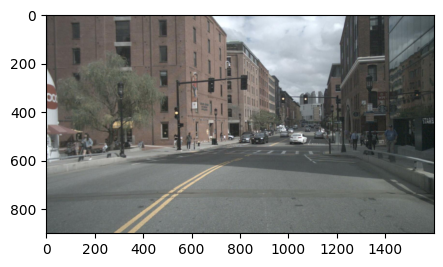

In [38]:
# load image file
image = cv2.imread(image_path)
height, width = image.shape[:2]
plt.subplots(1, 1, figsize=(5, 5))
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [39]:
points = load_bin(lidar_path)
points = points.T


points = np.dot(lidar_rotation,points)
points = points.T + lidar_translation_matrix

points = np.dot(lidar_ego_rotation,points.T)
points = points.T + lidar_ego_translation_matrix

points = points + camera_ego_translation_matrix
points = np.dot(camera_ego_rotation,points.T)

points = points.T + camera_translation_matrix
points = np.dot(camera_rotation,points.T)


In [40]:
points_cam = points.T
points_prj = np.dot(intrinsic_matrix,points_cam.T).T
points_prj /= points_prj[:, 2:3]


In [41]:
eff_inds = (
    (points_prj[:, 0] < width)
    & (points_prj[:, 0] >= 0)
    & (points_prj[:, 1] < height)
    & (points_prj[:, 1] >= 0)
)
eff_inds_where = np.where(eff_inds)[0]
eff_pcd_img = points_prj[eff_inds, :]


In [42]:
cmap = plt.cm.get_cmap("hsv", 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
img_lidar = np.copy(image)

for i in range(eff_pcd_img.shape[0]):
    pcd_cam_idx = eff_inds_where[i]
    pcd_cam_value = points_cam[pcd_cam_idx, :]
    depth = pcd_cam_value[2]
    if depth < -0 or depth > 150:
        continue
    color = cmap[int(abs(640.0 / depth)) % 256, :]
    cv2.circle(
        img_lidar,
        (int(np.round(eff_pcd_img[i, 0])), int(np.round(eff_pcd_img[i, 1]))),
        3,
        color=tuple(color),
        thickness=-1,
    )

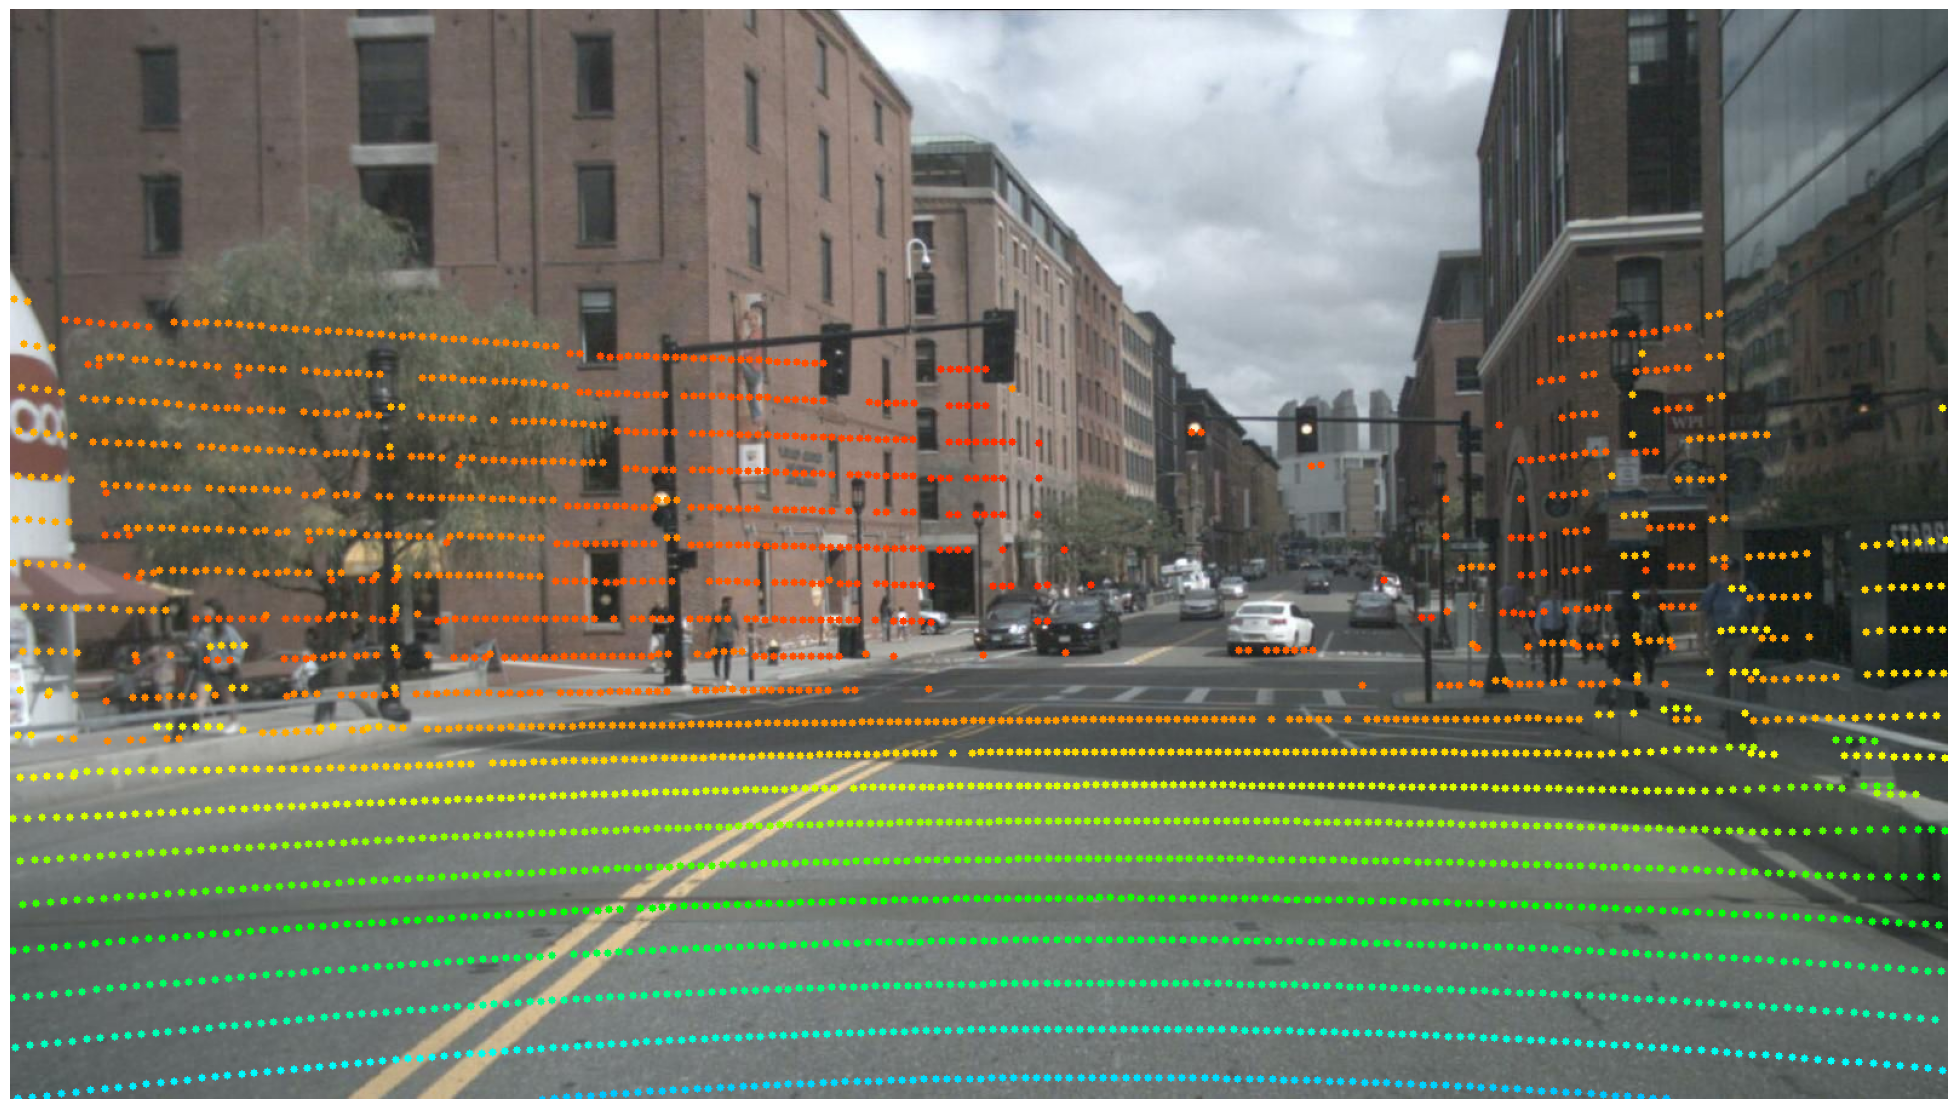

In [43]:
fig_lidar = plt.figure(figsize=(25, 15))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.axis('off')
plt.show()

In [44]:
# !pip install nuscenes-devkit

In [45]:
# %matplotlib inline # moved up
import matplotlib.pylab
from nuscenes.nuscenes import NuScenes
# import matplotlib.pylab


In [46]:
nusc = NuScenes(version='v1.0-mini', dataroot='/home/server-003/workspace/dataset/nuscenes/v1.0-mini/', verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.252 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [47]:
my_sample = nusc.sample[10]
# nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')


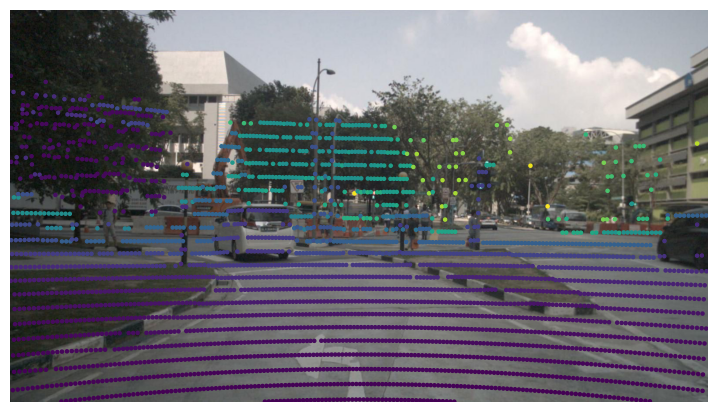

In [48]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')
